In [18]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from transformers import ViTImageProcessor, TFViTModel

%matplotlib inline

In [2]:
folder = "C:\\Users\\caleb\\OneDrive\\Desktop\\CSCE566_Project_Data"
flist = os.listdir(folder)

print(flist)

['test', 'train', 'val']


In [3]:
ftrain = os.path.join(folder, "train")
ftest = os.path.join(folder, "test")
fval = os.path.join(folder, "val")

def load_file(folder, idx):
    file = np.load(os.path.join(folder, os.listdir(folder)[idx]))
    return file

sample_data = load_file(ftrain, 0)
print("Data Features: ",sample_data.files, "\n")

print("Length of training set: ", len(os.listdir(ftrain)), "records")
print("Length of validation set: ", len(os.listdir(fval)), "records")
print("Length of testing set: ", len(os.listdir(ftest)), "records")

Data Features:  ['slo_fundus', 'race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype'] 

Length of training set:  4476 records
Length of validation set:  641 records
Length of testing set:  1914 records


# Exploratory Data Analysis

Unique RACE values: [0 1 2]
Unique MALE values: [0 1]
Unique HISPANIC values: [0 1]
Unique MARITALSTATUS values: [0 1 2 3 4]
Unique LANGUAGE values: [0 1 2]
Unique DR_CLASS values: [0 1]
Unique DR_SUBTYPE values: ['no.dr.diagnosis' 'pdr']

'slo_fundus' Image Shape:  (200, 200, 3)


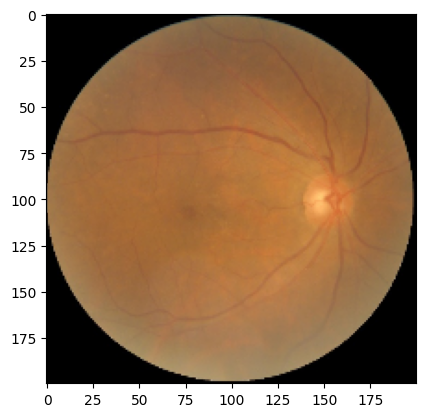

In [4]:
attr_dict = {attr: [] for attr in sample_data.files[1:]}

for idx in range(len(os.listdir(ftrain))):
    data = load_file(ftrain, idx)
    for attr in attr_dict.keys():
        attr_dict[attr].append(data[attr])

for attr in attr_dict.keys():
    print(f"Unique {attr.upper()} values:", np.unique(attr_dict[attr]))

print("\n'slo_fundus' Image Shape: ", sample_data['slo_fundus'].shape)
plt.imshow(sample_data['slo_fundus'][..., ::-1])
plt.show()


### Check Data Distribution

Positive Cases: 1118  / Negative Cases: 3358
Males: 2390  / Females: 2086


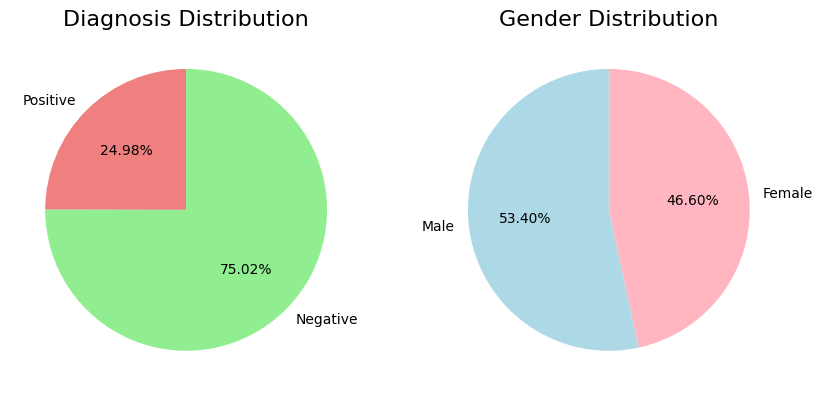

In [5]:
# Check the diagnosis distribution in the training data
positive_count = sum(attr_dict['dr_class'])
negative_count = len(attr_dict['dr_class']) - positive_count
label_counts = [positive_count, negative_count]
print("Positive Cases:", positive_count, " / Negative Cases:", negative_count)

# Check the gender distribution in the training data
male_count = sum(attr_dict['male'])
female_count = len(attr_dict['male']) - male_count
gender_counts = [male_count, female_count]
print("Males:", male_count, " / Females:", female_count)

# Visualize the diagnosis and gender distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(label_counts, labels=['Positive', 'Negative'], autopct='%1.2f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
ax[0].set_title('Diagnosis Distribution', fontsize=16)
ax[1].pie(gender_counts, labels=['Male', 'Female'], autopct='%1.2f%%', startangle=90, colors=['lightblue', 'lightpink'])
ax[1].set_title('Gender Distribution', fontsize=16)

plt.show()

##### The gender of the sample patients seem to be roughly balanced with about 7% more males than females. The diagnosis distribution is very imbalanced however, which may make modeling of the data more challenging.
#

### Check Image and Label consistency

In [6]:
# Check that dr_subtype class is redundant with dr_class
for i, label in enumerate(attr_dict['dr_class']):
    if label == 1 and attr_dict['dr_subtype'][i] != 'pdr':
        print("Mismatched Label: ", i)
else:
    print("'dr_subtype' is a redundant feature:\n'dr_class': 1 == 'dr_subtype': PDR (proliferative diabetic retinopathy)")

# Check for consisten image shapes
print("\nChecking image shapes in each folder...")
for folder in [ftrain, fval, ftest]:
    folder_name = folder.split("\\")[-1].upper()
    for idx in range(len(os.listdir(folder))):
        data = load_file(folder, idx)
        if data['slo_fundus'].shape != (200, 200, 3):
            print(f"Image shape mismatch in {folder_name} DATA at index {idx}: {data['slo_fundus'].shape}")
    print(f"Image shapes in {folder_name} DATA are consistent: {data['slo_fundus'].shape}")

'dr_subtype' is a redundant feature:
'dr_class': 1 == 'dr_subtype': PDR (proliferative diabetic retinopathy)

Checking image shapes in each folder...
Image shapes in TRAIN DATA are consistent: (200, 200, 3)
Image shapes in VAL DATA are consistent: (200, 200, 3)
Image shapes in TEST DATA are consistent: (200, 200, 3)


### Compare POSITIVE vs. NEGATIVE diagnosis images

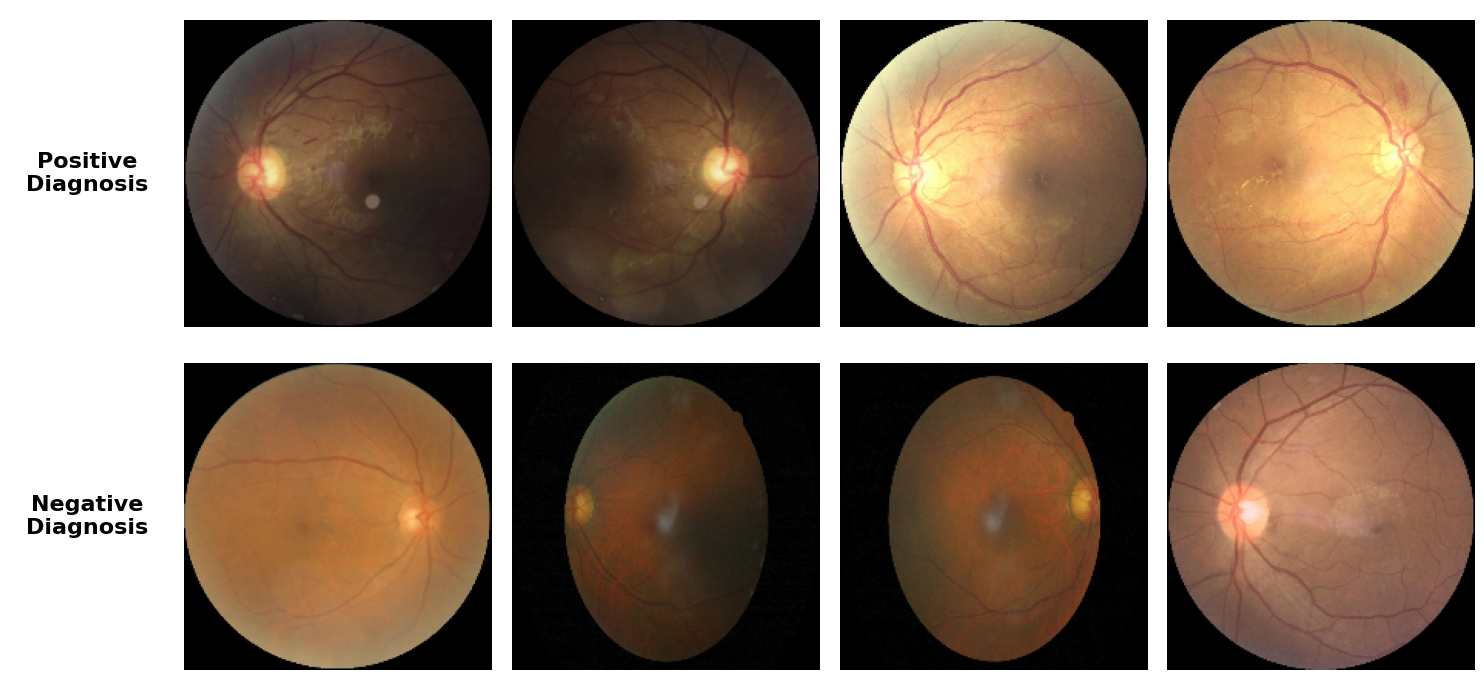

In [7]:
positive_indices = [i for i, label in enumerate(attr_dict['dr_class']) if label == 1]
negative_indices = [i for i, label in enumerate(attr_dict['dr_class']) if label == 0]

positive_images = [load_file(ftrain, i)['slo_fundus'] for i in positive_indices[:4]]
negative_images = [load_file(ftrain, i)['slo_fundus'] for i in negative_indices[:4]]

fig, ax = plt.subplots(2, 5, figsize=(15, 7), gridspec_kw={'width_ratios': [0.5, 1, 1, 1, 1]})
ax[0, 0].text(0.5, 0.5, 'Positive\nDiagnosis', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[0, 0].axis('off')
ax[1, 0].text(0.5, 0.5, 'Negative\nDiagnosis', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[1, 0].axis('off')

for i in range(4):
    ax[0, i+1].imshow(positive_images[i][..., ::-1])
    ax[0, i+1].axis('off')
    ax[1, i+1].imshow(negative_images[i][..., ::-1])
    ax[1, i+1].axis('off')

plt.tight_layout()
plt.show()


##### The images above show inconsistency in the lighting conditions, zoom, and angle of the retina scans, which can limit the ability of a NN models to identify generalizable features. Adding additional contrast to the images can help features stand out, especially on darker images. During a literature review of related work, a technique called Contrast Limited Adaptive Histogram Equalization (CLAHE) was identified to effectively enhance the details of the images and to mitigate some of the lighting inconsistencies. Cropping was also used to mitigate some of the inconsistences in zoom and angle that resulted in extra space around the circular fundus.
#

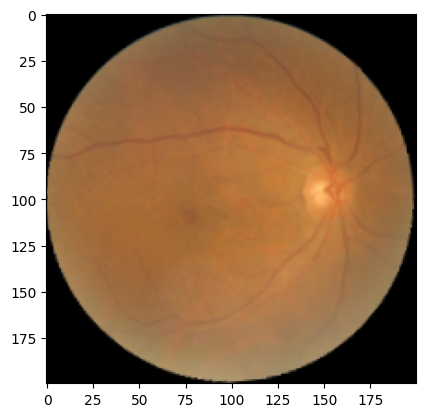

In [12]:
def augment_image(image):
    if random.random() < 0.5:
        image = cv2.flip(image, 1)

    angle = random.uniform(-90, 90)
    center = (image.shape[1] / 2, image.shape[0] / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return image

plt.imshow(augment_image(sample_data['slo_fundus'])[..., ::-1])


In [13]:
def remove_extra_space(img, resize_dim, tol=7):
    # Mask pixels values with values over the tolerance level (tol)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img > tol
    
    # Check if the image is too dark to crop
    check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
    if check_shape == 0:
        return img
    else:
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        img = np.stack([img1, img2, img3], axis=-1)

    img = cv2.resize(img, (resize_dim, resize_dim), interpolation=cv2.INTER_AREA)

    return img

def circle_crop(img, resize_dim=224):
    img = remove_extra_space(img, resize_dim)

    # Get the center and radius of the image
    height, width, _ = img.shape    
    x = int(width / 2)
    y = int(height / 2)
    r = min(x, y)

    # Crop using the circular mask
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    
    img = remove_extra_space(img, resize_dim)

    return img

In [18]:
def apply_clahe(img, clip=2.5):
    # Convert the image from RGB to LAB color space
    img = circle_crop(img)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(img_lab)

    # Create CLAHE filter and apply it to each channel
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    ca = clahe.apply(a_channel)
    cb = clahe.apply(b_channel)

    # Merge the CLAHE enhanced channels and convert back to RGB
    merged_lab = cv2.merge((cl, ca, cb))
    enhanced_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)
    #enhanced_img = cv2.addWeighted(enhanced_img, 4, cv2.GaussianBlur(enhanced_img, (0, 0), enhanced_img.shape[0] / 30), -4, 128)

    return enhanced_img

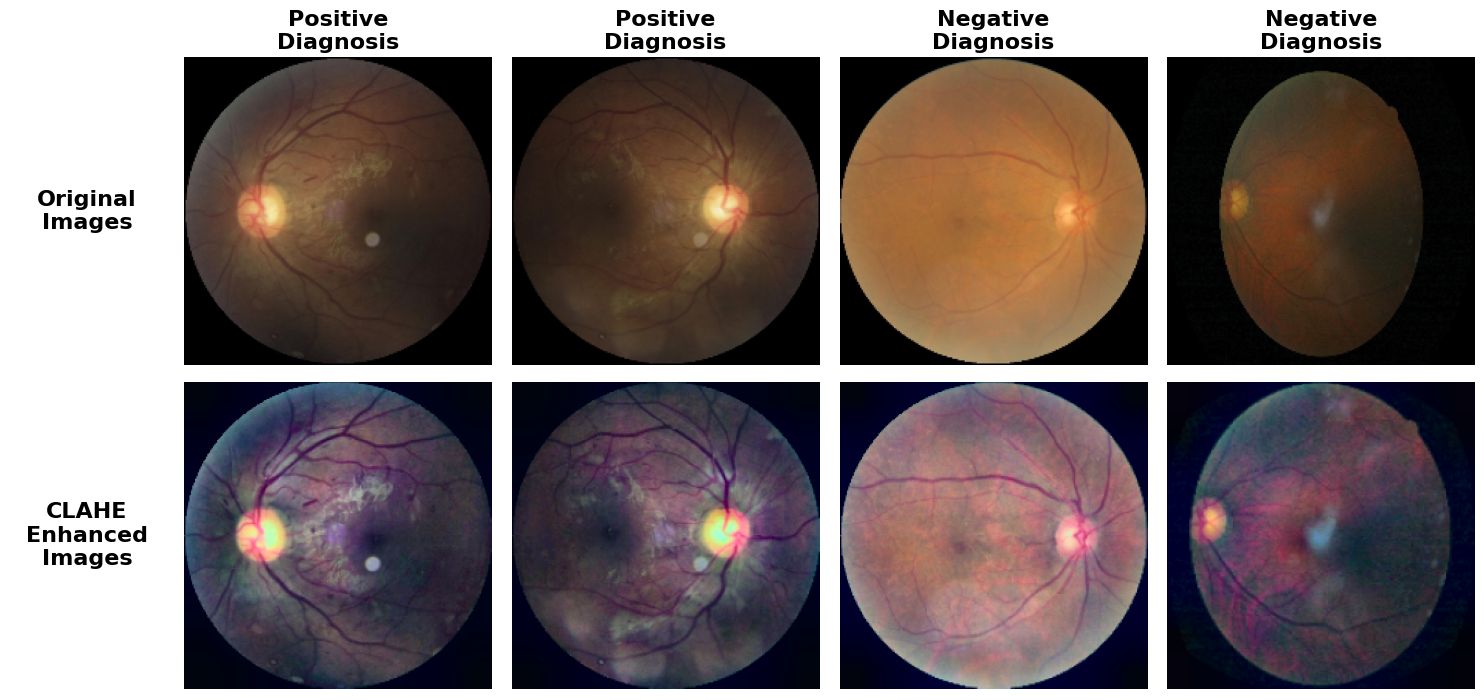

In [19]:
clahe_positive_images = [apply_clahe(img) for img in positive_images]
clahe_negative_images = [apply_clahe(img) for img in negative_images]

fig, ax = plt.subplots(2, 5, figsize=(15, 7), gridspec_kw={'width_ratios': [0.5, 1, 1, 1, 1]})
ax[0, 0].text(0.5, 0.5, 'Original\nImages', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[0, 0].axis('off')
ax[1, 0].text(0.5, 0.5, 'CLAHE\nEnhanced\nImages', horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')
ax[1, 0].axis('off')

for i in range(2):
    ax[0, i+1].imshow(positive_images[i][..., ::-1])
    ax[0, i+1].set_title('Positive\nDiagnosis', fontsize=16, fontweight='bold')
    ax[0, i+1].axis('off')
    ax[0, i+3].imshow(negative_images[i][..., ::-1])
    ax[0, i+3].set_title('Negative\nDiagnosis', fontsize=16, fontweight='bold')
    ax[0, i+3].axis('off')
    ax[1, i+1].imshow(clahe_positive_images[i][..., ::-1])
    ax[1, i+1].axis('off')
    ax[1, i+3].imshow(clahe_negative_images[i][..., ::-1])
    ax[1, i+3].axis('off')

plt.tight_layout()
plt.show()

##### Cropping and applying a CLAHE filter to the color fundus images does seem to make the vasculature and other features more defined, so it was used for preprocessing the images within the datagenerator below.
#

Using Vision Transformer (ViT) Model:
Generator Batch Shape:  (10, 3, 224, 224)
Sample Range of RGB Values:  [-0.96862745, 1.0]


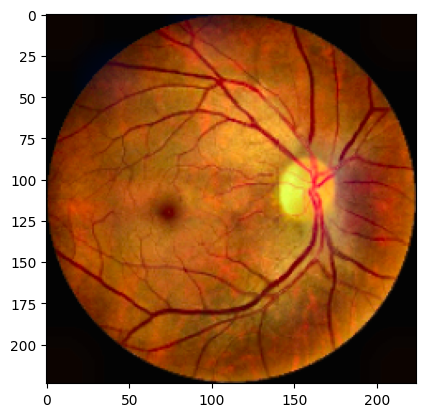

Using Convolutional Neural Network (CNN) Model

Generator Batch Shape:  (10, 224, 224, 3)
Sample Range of RGB Values:  [0.0, 245.0]


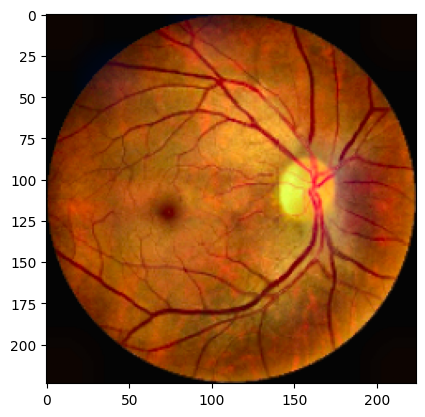

In [ ]:
image_processor = ViTImageProcessor()

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, shape, batch_size=8, shuffle=True, clahe=False, augment=False, use_vit=False, **kwargs):
        super().__init__(**kwargs)
        self.folder = folder
        self.shape = shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.clahe = clahe
        self.augment = augment
        self.use_vit = use_vit
        self.flist = os.listdir(folder)
        self.indexes = np.arange(len(self.flist))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.flist) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.flist[i] for i in batch_indexes]
        X, y = self.__data_generation(batch_files)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_files):
        X = np.empty((self.batch_size, *self.shape), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int32)
        
        for i, f in enumerate(batch_files):
            data = np.load(os.path.join(self.folder, f))
            image = data['slo_fundus'][..., ::-1]
            image = augment_image(image) if self.augment else image
            image = apply_clahe(image, 2.5) if self.clahe else image
            X[i,] = image
            y[i] = data['dr_class']
        
        if self.use_vit:
            X = image_processor(X, return_tensors="tf")['pixel_values']
        
        return X, y
    
batch_size = 10
train_generator = DataGenerator(ftrain, shape=(224, 224, 3), batch_size=batch_size, shuffle=True, clahe=True, use_vit=True)
validation_generator = DataGenerator(fval, shape=(224, 224, 3), batch_size=batch_size, shuffle=False, clahe=True)
test_generator = DataGenerator(ftest, shape=(224, 224, 3), batch_size=batch_size, shuffle=False, clahe=True)

sample = train_generator.__getitem__(0)[0]
print("Using Vision Transformer (ViT) Model:")
print("Generator Batch Shape: ", sample.shape)
print("Sample Range of RGB Values: ", [tf.reduce_min(sample[0, 0, 100]).numpy(), tf.reduce_max(sample[0, 0, 100]).numpy()])
image = (sample[0] + 1) / 2  # Convert to [0, 1] range
plt.imshow(tf.transpose(image, perm=[1, 2, 0]))
plt.show()

train_generator.use_vit = False
print("Using Convolutional Neural Network (CNN) Model:")
sample = train_generator.__getitem__(0)[0]
print("Generator Batch Shape: ", sample.shape)
print("Sample Range of RGB Values: ", [min(sample[0, :, 100, 0]), max(sample[0, :, 100, 0])])
image = (sample[0]) / 255.0
plt.imshow(image)
plt.show()





### Check for label data consistency across all datasets

Positive label occurance in Train Data: 24.99%  (Batch Count: 447  /  Record Count: 4470  /  Unique Label Values: [0 1])
Positive label occurance in Val Data: 28.44%  (Batch Count: 64  /  Record Count: 640  /  Unique Label Values: [0 1])
Positive label occurance in Test Data: 25.65%  (Batch Count: 191  /  Record Count: 1910  /  Unique Label Values: [0 1])


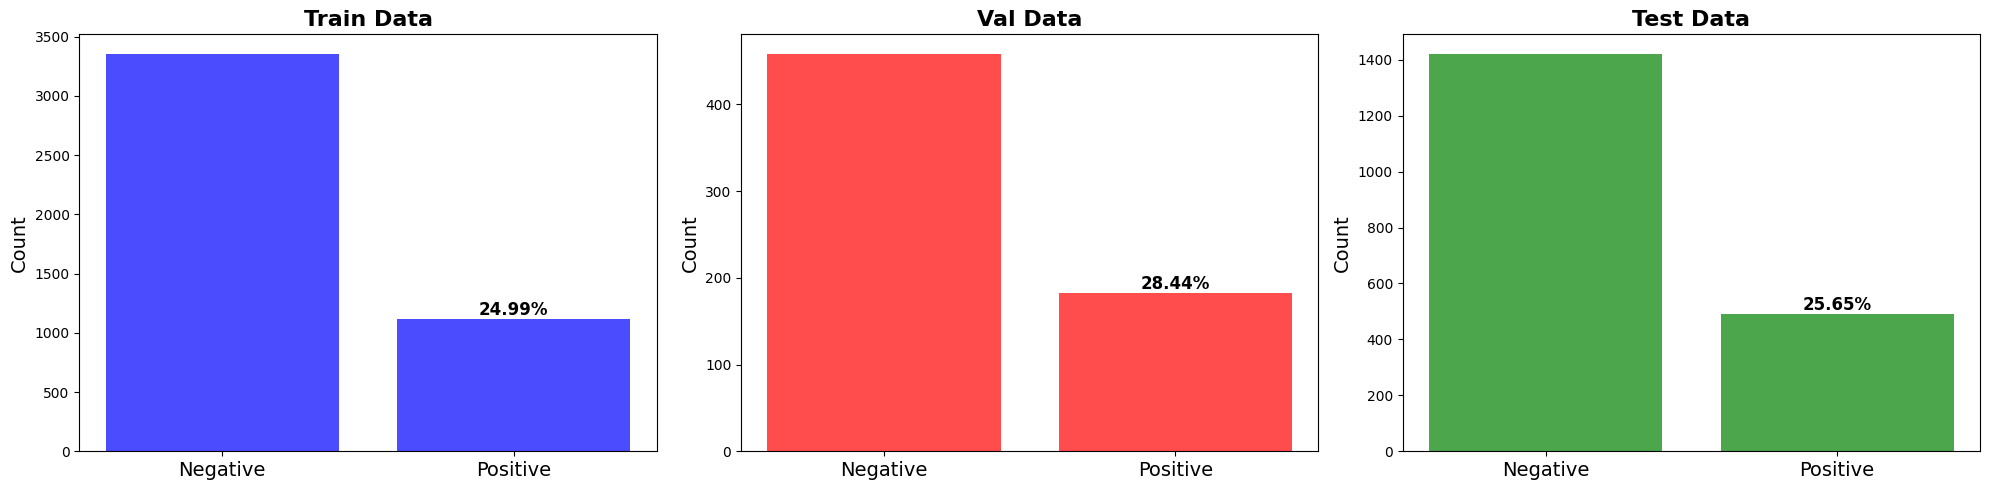

In [24]:
# Check label distribution across datasets
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
color = ['blue', 'red', 'green']

for i, generator in enumerate([train_generator, validation_generator, test_generator]):
    label_data = []
    for j in range(generator.__len__()):
        _, labels = generator.__getitem__(j)
        label_data.extend(labels)
    
    values, counts = np.unique(label_data, return_counts=True)
    positive_percentage = round((sum(label_data)/len(label_data)) * 100, 2)
    data_name = generator.folder.split('\\')[-1].capitalize()

    print(f"Positive label occurance in {data_name} Data: {positive_percentage}%  (Batch Count: {generator.__len__()}  /  Record Count: {len(label_data)}  /  Unique Label Values: {values})")

    ax[i].bar(values, counts, color=color[i], alpha=0.7)
    ax[i].set_title(f"{data_name} Data", fontsize=16, fontweight='bold')
    ax[i].set_ylabel("Count", fontsize=14)
    ax[i].set_xticks(values)
    ax[i].set_xticklabels(['Negative', 'Positive'], fontsize=14)
    ax[i].text(values[1], counts[1], f'{positive_percentage}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Check for data leakage between datasets

In [25]:
def check_overlap(generator1, generator2, name1, name2):
    print(f"Checking overlap between {name1.upper()} and {name2.upper()} datasets...")
    overlap_count = 0
    images1_set = set()
    
    for i in range(len(generator1)):
        images1, _ = generator1.__getitem__(i)
        for img1 in images1:
            images1_set.add(img1.tobytes())
    
    for j in range(len(generator2)):
        images2, _ = generator2.__getitem__(j)
        for img2 in images2:
            if img2.tobytes() in images1_set:
                overlap_count += 1
    
    print(f"Overlap between {name1.upper()} and {name2.upper()}: {overlap_count} images")

train_generator.augment = False
check_overlap(train_generator, validation_generator, "Training", "Validation")
check_overlap(train_generator, test_generator, "Training", "Test")
check_overlap(validation_generator, test_generator, "Validation", "Test")
train_generator.augment = True

Checking overlap between TRAINING and VALIDATION datasets...
Overlap between TRAINING and VALIDATION: 0 images
Checking overlap between TRAINING and TEST datasets...
Overlap between TRAINING and TEST: 0 images
Checking overlap between VALIDATION and TEST datasets...
Overlap between VALIDATION and TEST: 640 images


##### It seems that almost all of the images from the validation set are also contained within the test set. Ideally, these two datasets would be exclusive from one another to better assess the generalizability of the model. Since neither set has any overlap with the training images, however, it will not cause any issues with the training process directly.
#

## Model Training

In [26]:
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(attr_dict['dr_class']),
    y = np.array(attr_dict['dr_class'])
)

class_weights = {0 : class_weights[0], 1 : class_weights[1]}
print ("Class weights: ", class_weights)

Class weights:  {0: 0.6664681357951161, 1: 2.001788908765653}


In [36]:
def build_model_efficient(img_size=224, channel=3, num_classes=1, trainable_start=-15, dropout=0.5):
    input_shape=(img_size, img_size, channel)
    img = tf.keras.layers.Input(shape=input_shape)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    
    base_model = tf.keras.applications.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_tensor=img,
        pooling=None
    )
    
    base_model.trainable = True
    for layer in base_model.layers[trainable_start:]:
        layer.trainable = True

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=img, outputs=output_layer)
    
    return model

def build_model_efficient2(img_size=224, channel=3, num_classes=1, trainable_start=-15, layer_size=512, dropout=0.2):
    input_shape=(img_size, img_size, channel)
    img = tf.keras.layers.Input(shape=input_shape)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    
    base_model = tf.keras.applications.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_tensor=img,
        pooling=None
    )
    
    base_model.trainable = False
    for layer in base_model.layers[trainable_start:]:
        layer.trainable = True

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(layer_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

    return model
    

model = build_model_efficient()

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
    loss = 'binary_crossentropy',
    metrics = ['acc', 'AUC']
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 tf.math.multiply_3 (TFOpLa  (None, 224, 224, 3)          0         ['normalization_3[0][0]'

In [37]:
train_generator.use_vit = False
validation_generator.use_vit = False
test_generator.use_vit = False
history = model.fit(
    train_generator,
    epochs = 80,
    verbose = 1,
    validation_data = validation_generator,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8)]
)

Epoch 1/80
447/447 [==============================] - 269s 543ms/step - loss: 0.6505 - acc: 0.6114 - auc: 0.5367 - val_loss: 0.6122 - val_acc: 0.7047 - val_auc: 0.5805 - lr: 1.0000e-05
Epoch 2/80
447/447 [==============================] - 234s 523ms/step - loss: 0.5723 - acc: 0.7221 - auc: 0.6033 - val_loss: 0.5756 - val_acc: 0.7156 - val_auc: 0.6315 - lr: 1.0000e-05
Epoch 3/80
447/447 [==============================] - 216s 482ms/step - loss: 0.5476 - acc: 0.7331 - auc: 0.6391 - val_loss: 0.5602 - val_acc: 0.7266 - val_auc: 0.6647 - lr: 1.0000e-05
Epoch 4/80
447/447 [==============================] - 229s 513ms/step - loss: 0.5260 - acc: 0.7474 - auc: 0.6755 - val_loss: 0.5596 - val_acc: 0.7266 - val_auc: 0.6752 - lr: 1.0000e-05
Epoch 5/80
447/447 [==============================] - 220s 492ms/step - loss: 0.5203 - acc: 0.7519 - auc: 0.6872 - val_loss: 0.5579 - val_acc: 0.7344 - val_auc: 0.6894 - lr: 1.0000e-05
Epoch 6/80
447/447 [==============================] - 218s 486ms/step - los

In [ ]:
print(history.history.keys())

dict_keys(['acc', 'auc', 'loss', 'val_acc', 'val_auc', 'val_loss'])


In [38]:
def plot_model_history(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    auc = history['auc']
    val_auc = history['val_auc']

    plt.figure(figsize=(14, 10))
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation auc
    plt.subplot(2, 2, 3)
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Baseline Model Results:
Best Validation Accuracy:  0.77
Lowest Validation Loss:  0.54 

Accuracy:  0.81  / AUC:  0.81  / Loss:  0.43
Validation Accuracy:  0.77  / Validation AUC:  0.75  / Validation Loss:  0.56


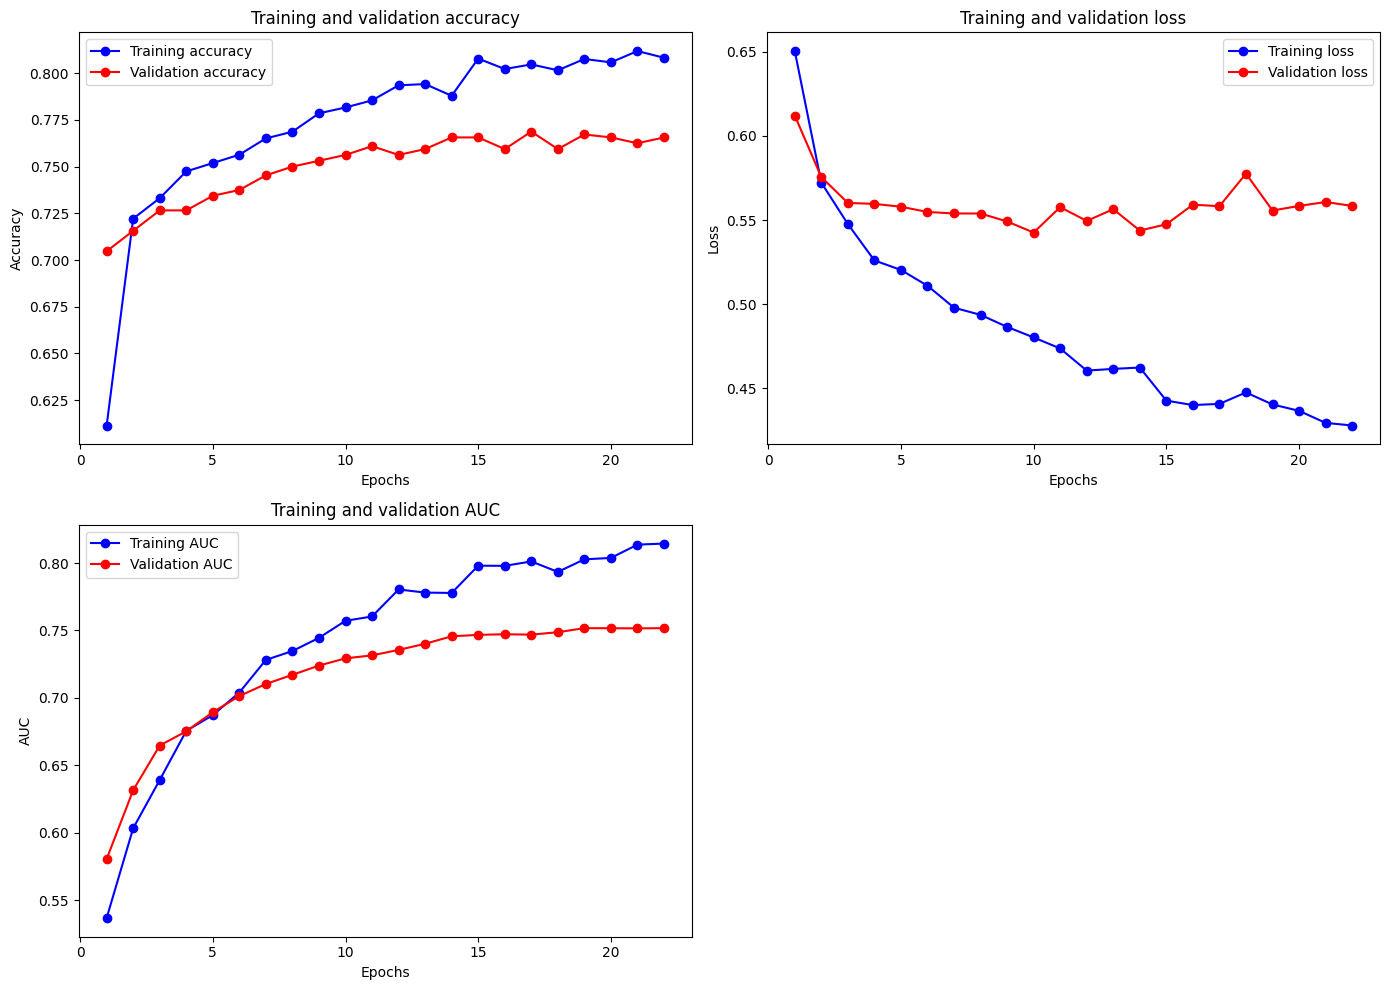

In [39]:
print("Baseline Model Results:")
print("Best Validation Accuracy: ", round(max(history.history['val_acc']), 2))
print("Lowest Validation Loss: ", round(min(history.history['val_loss']), 2), "\n")
print("Accuracy: ", round(history.history['acc'][-1], 2), " / AUC: ", round(history.history['auc'][-1], 2), " / Loss: ", round(history.history['loss'][-1], 2))
print("Validation Accuracy: ", round(history.history['val_acc'][-1], 2), " / Validation AUC: ", round(history.history['val_auc'][-1], 2), " / Validation Loss: ", round(history.history['val_loss'][-1], 2))
plot_model_history(history.history)

Baseline Model Results:
Best Validation Accuracy:  0.75
Lowest Validation Loss:  0.51 

Accuracy:  0.77  / AUC:  0.76  / Loss:  0.48
Validation Accuracy:  0.75  / Validation AUC:  0.75  / Validation Loss:  0.51


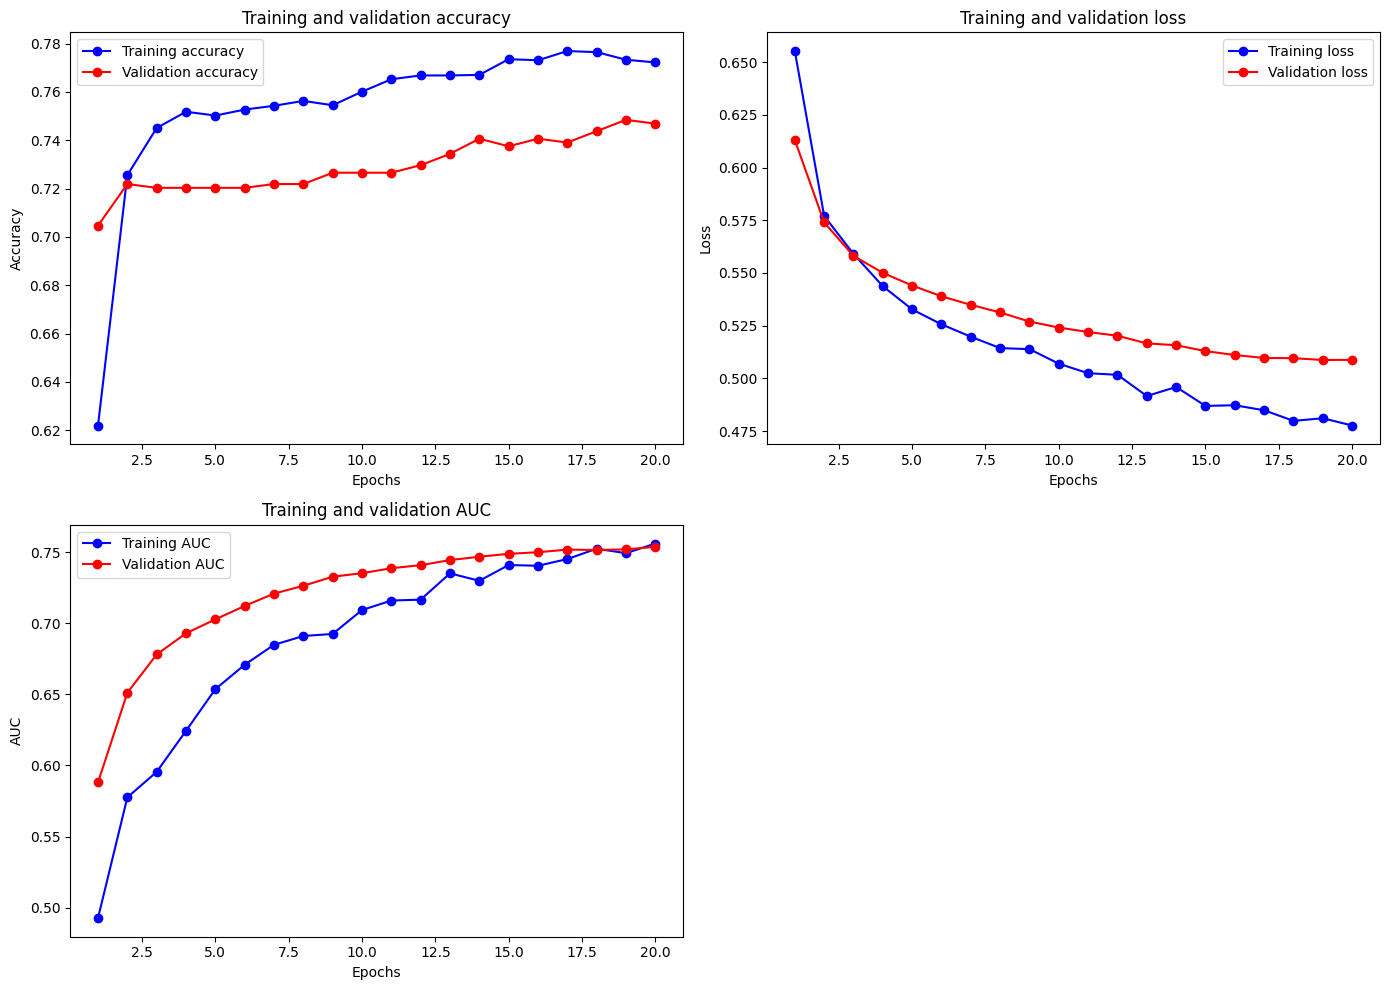

In [321]:
print("Baseline Model Results:")
print("Best Validation Accuracy: ", round(max(history.history['val_acc']), 2))
print("Lowest Validation Loss: ", round(min(history.history['val_loss']), 2), "\n")
print("Accuracy: ", round(history.history['acc'][-1], 2), " / AUC: ", round(history.history['auc'][-1], 2), " / Loss: ", round(history.history['loss'][-1], 2))
print("Validation Accuracy: ", round(history.history['val_acc'][-1], 2), " / Validation AUC: ", round(history.history['val_auc'][-1], 2), " / Validation Loss: ", round(history.history['val_loss'][-1], 2))
plot_model_history(history.history)

In [ ]:
import json
params = {
    'use_class_weights': [False], # Perm
    'clahe': [True],
    'trainable_Start': [-15, -18],
    'layer_size': [512],
    'dropout': [0.5, 0.6],
    'learning_rate': [0.00001]
}

ops_count = np.prod([len(v) for v in params.values()])
print(f"Total Model Iterations to Test: {ops_count}")

idx = 0
for use_class_weights in params['use_class_weights']:
    for clahe in params['clahe']:
        for trainable_start in params['trainable_Start']:
            for layer_size in params['layer_size']:
                for dropout in params['dropout']:
                    for learning_rate in params['learning_rate']:
                        idx += 1
                        iter_params = {
                            'use_class_weights': use_class_weights,
                            'clahe': clahe,
                            'trainable_start': trainable_start,
                            'layer_size': layer_size,
                            'dropout': dropout,
                            'learning_rate': learning_rate
                        }
                        
                        print(f"\nIteration {idx}")
                        print(iter_params, "\n")

                        train_generator = DataGenerator(ftrain, shape=(224, 224, 3), batch_size=batch_size, shuffle=True, clahe=clahe, augment=True)
                        validation_generator = DataGenerator(fval, shape=(224, 224, 3), batch_size=batch_size, shuffle=False, clahe=clahe)

                        model = build_model_efficient2(
                            trainable_start=trainable_start,
                            layer_size=layer_size,
                            dropout=dropout
                        )

                        model.compile(
                            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                            loss = 'binary_crossentropy',
                            metrics = ['acc', 'AUC']
                        )

                        early_stopping = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=12
                        )

                        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.1,
                            verbose=1,
                            patience=8,
                            min_lr=0.000001
                        )

                        if use_class_weights:
                            cw = class_weights
                        else:
                            cw = None
                        
                        history = model.fit(
                            train_generator,
                            validation_data = validation_generator,
                            epochs = 80,
                            class_weight = cw,
                            callbacks = [early_stopping, lr_reducer],
                        )

                        result = {
                            'iteration': idx,
                            'params': iter_params,
                            'history': history.history
                        }

                        with open(f"grid_search_results.json", 'a') as f:
                            json.dump(result, f)
                            f.write('\n')

print("\nGrid Search Complete!")
                        

Total Model Iterations to Test: 4

Iteration 1
{'use_class_weights': False, 'clahe': True, 'trainable_start': -15, 'layer_size': 512, 'dropout': 0.5, 'learning_rate': 1e-05} 

Epoch 1/80


TypeError: in user code:

    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  *
        outputs = model.train_step(data)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\engine\training.py", line 1152, in train_step  *
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\engine\training.py", line 1246, in compute_metrics  *
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\engine\compile_utils.py", line 620, in update_state  *
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\metrics\base_metric.py", line 153, in decorated  *
        result = update_state_fn(*args, **kwargs)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\metrics\base_metric.py", line 140, in update_state_fn  *
        return ag_update_state(*args, **kwargs)
    File "c:\Users\caleb\miniconda3\envs\tf\lib\site-packages\tf_keras\src\metrics\base_metric.py", line 722, in update_state  *
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


Best Validation Accuracy:  75.62500238418579 % (Model Number:  4 )
Best Validation AUC:  75.68740844726562 % (Model Mumber:  7 )
Lowest Validation Loss:  0.5083960890769958 (Model Number:  7 )

Model Number:  1
{'use_class_weights': False, 'clahe': True, 'trainable_start': -12, 'layer_size': 512, 'dropout': 0.4, 'learning_rate': 1e-05}
Accuracy:  0.75  / AUC:  0.75  / Loss:  0.51
Validation Accuracy:  0.74  / Validation AUC:  0.75  / Validation Loss:  0.52


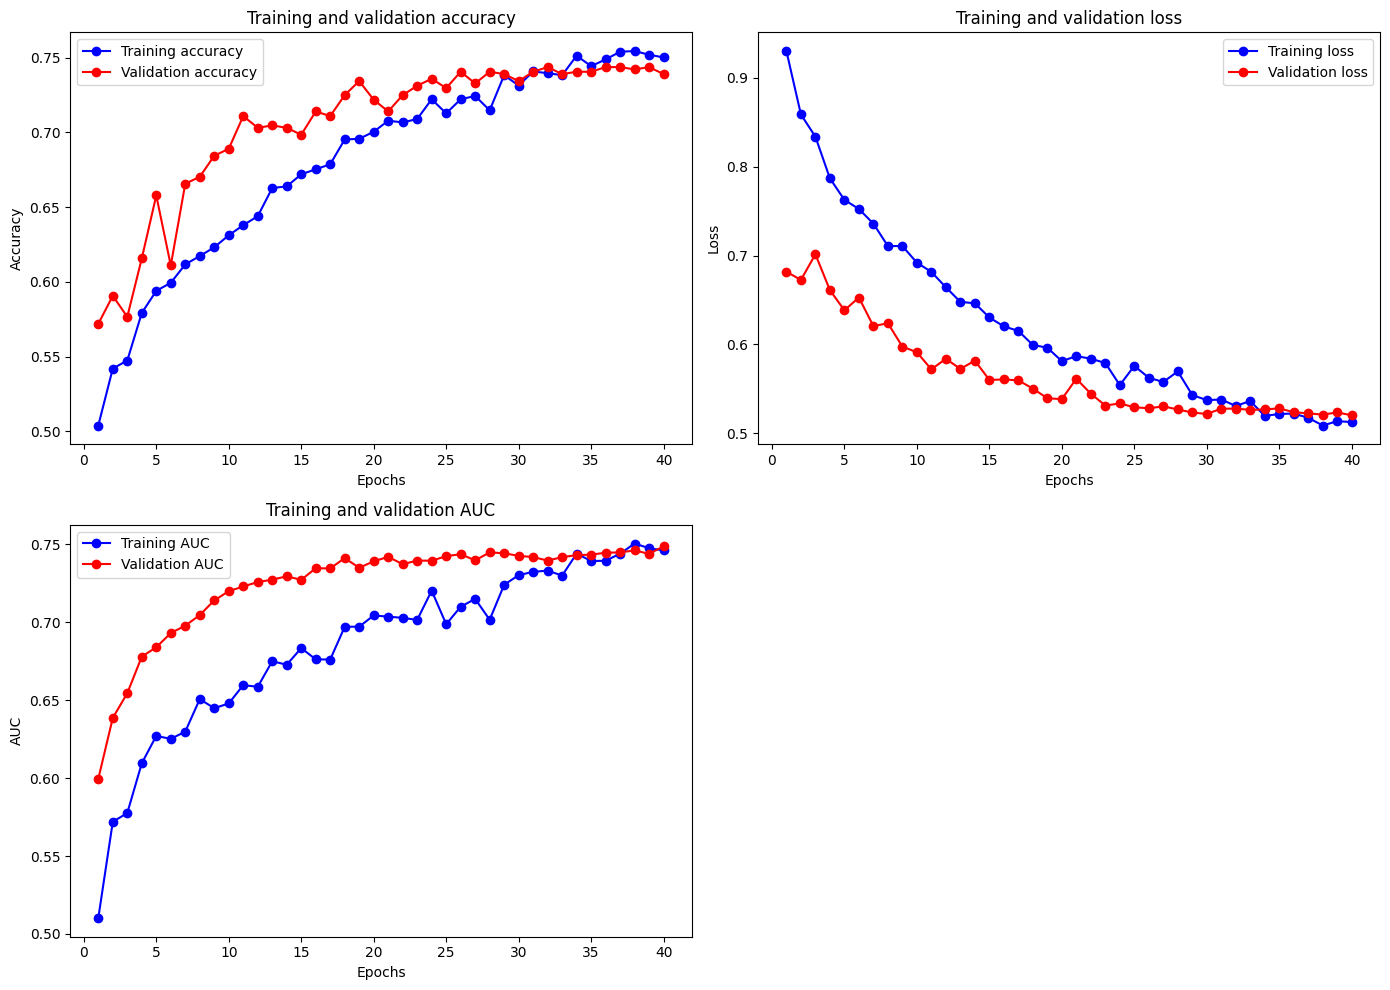


Model Number:  2
{'use_class_weights': False, 'clahe': True, 'trainable_start': -12, 'layer_size': 512, 'dropout': 0.5, 'learning_rate': 1e-05}
Accuracy:  0.73  / AUC:  0.72  / Loss:  0.56
Validation Accuracy:  0.74  / Validation AUC:  0.73  / Validation Loss:  0.54


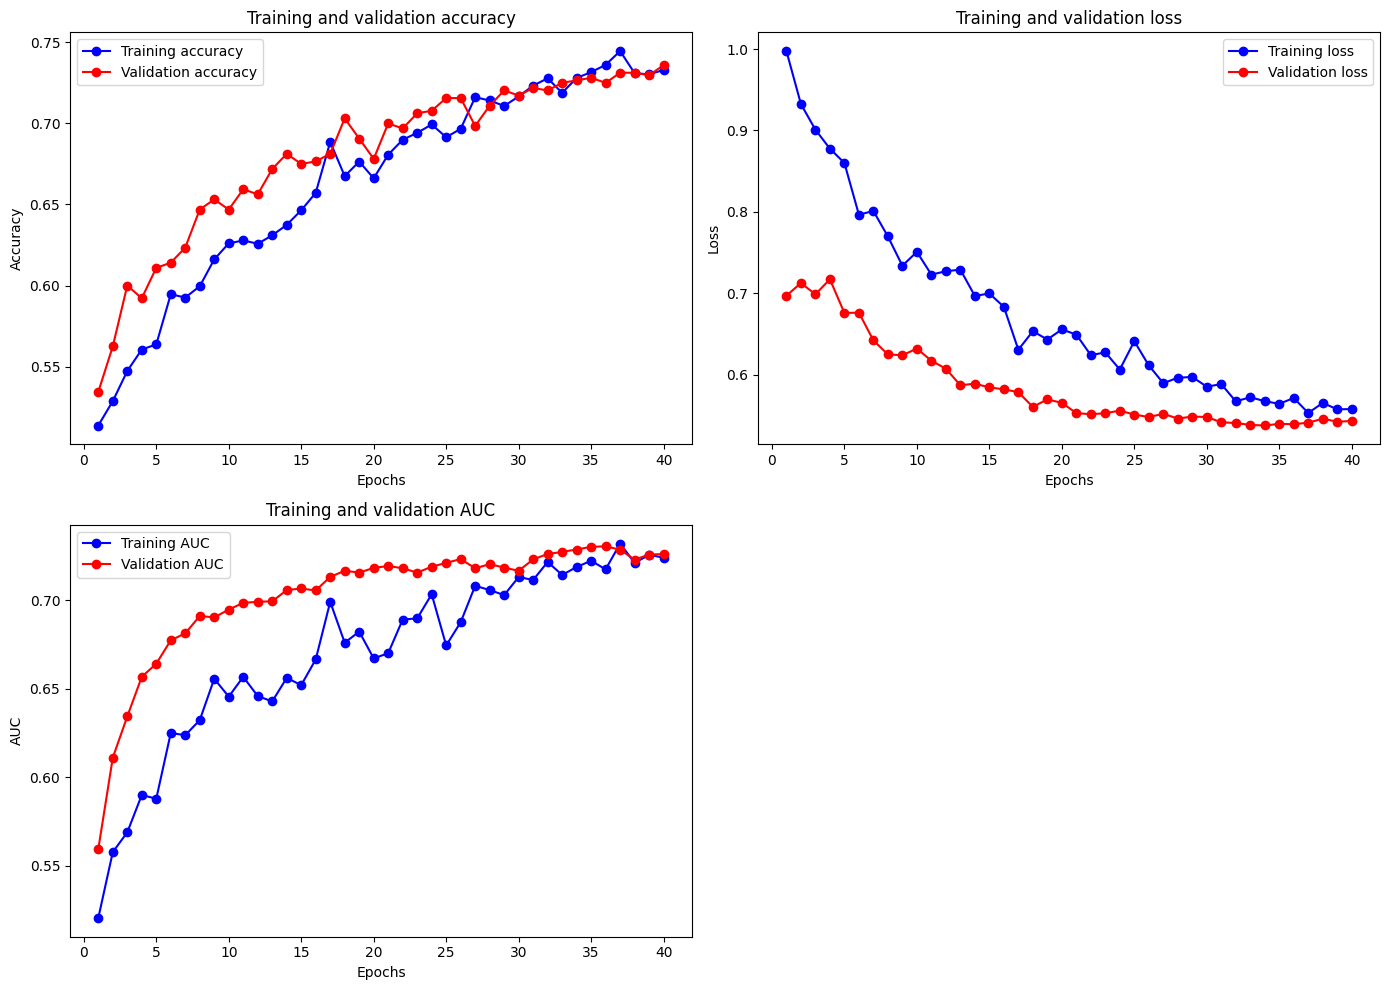


Model Number:  3
{'use_class_weights': False, 'clahe': True, 'trainable_start': -12, 'layer_size': 512, 'dropout': 0.6, 'learning_rate': 1e-05}
Accuracy:  0.7  / AUC:  0.71  / Loss:  0.6
Validation Accuracy:  0.74  / Validation AUC:  0.73  / Validation Loss:  0.54


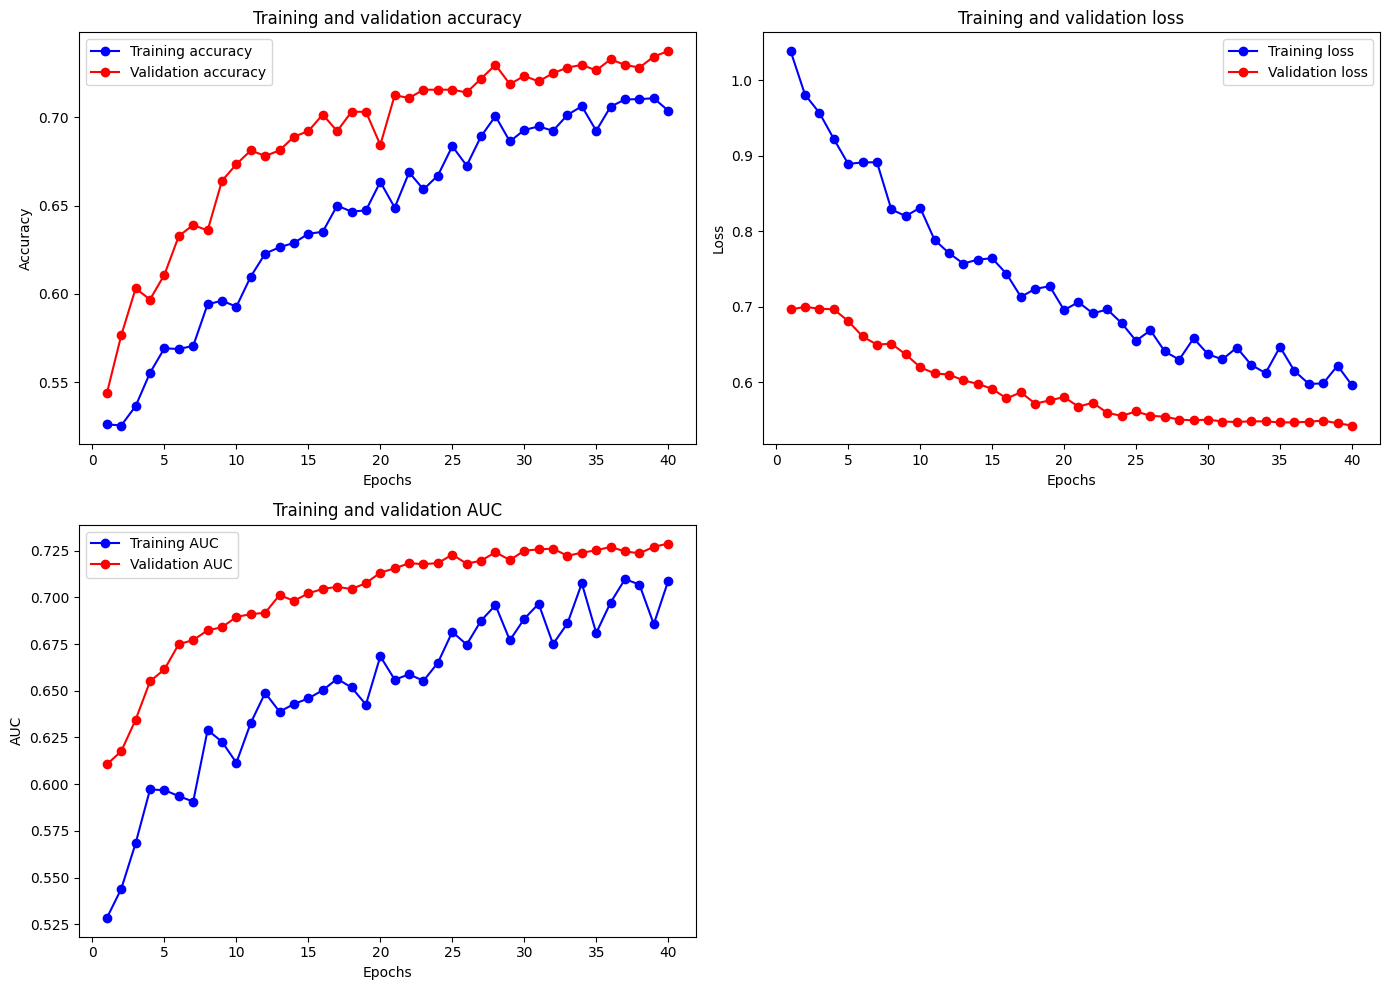


Model Number:  4
{'use_class_weights': False, 'clahe': True, 'trainable_start': -15, 'layer_size': 512, 'dropout': 0.4, 'learning_rate': 1e-05}
Accuracy:  0.76  / AUC:  0.76  / Loss:  0.5
Validation Accuracy:  0.74  / Validation AUC:  0.74  / Validation Loss:  0.52


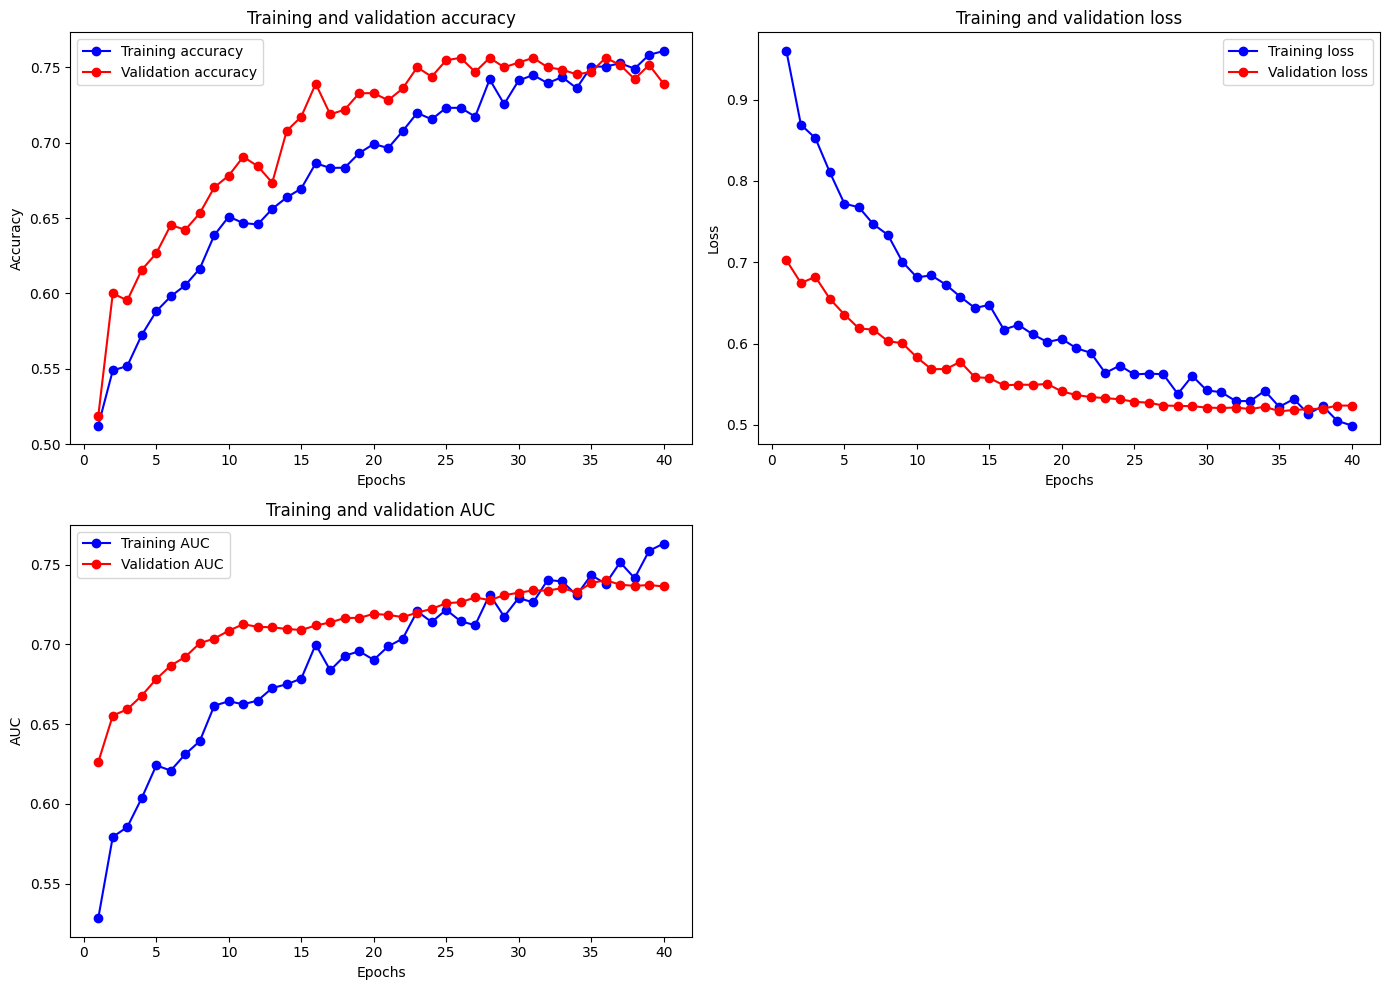


Model Number:  5
{'use_class_weights': False, 'clahe': True, 'trainable_start': -15, 'layer_size': 512, 'dropout': 0.5, 'learning_rate': 1e-05}
Accuracy:  0.73  / AUC:  0.72  / Loss:  0.56
Validation Accuracy:  0.74  / Validation AUC:  0.73  / Validation Loss:  0.53


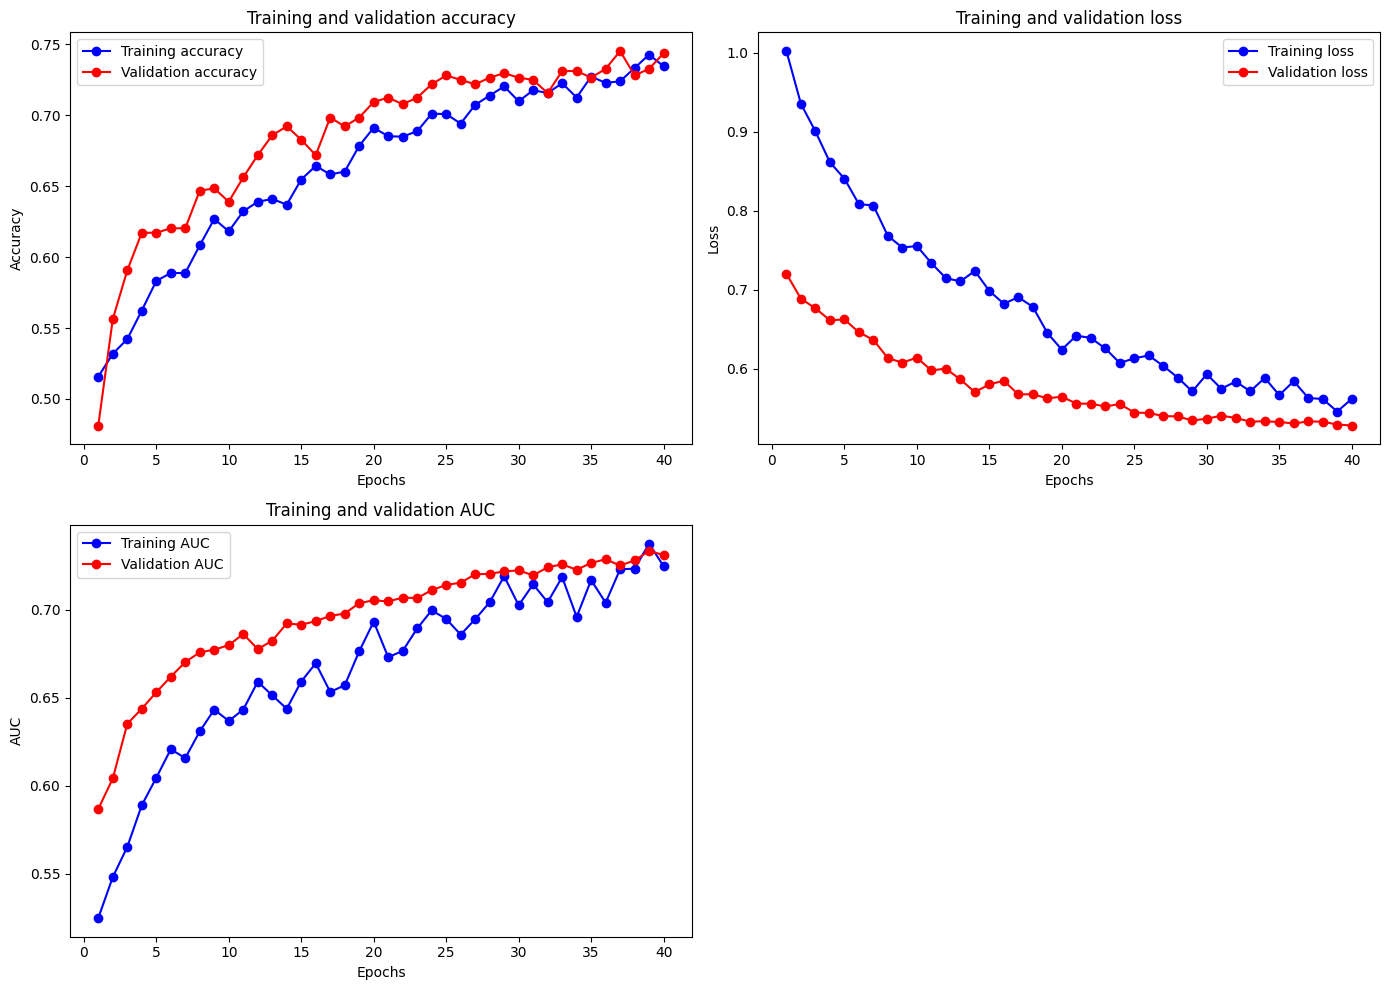


Model Number:  6
{'use_class_weights': False, 'clahe': True, 'trainable_start': -15, 'layer_size': 512, 'dropout': 0.6, 'learning_rate': 1e-05}
Accuracy:  0.71  / AUC:  0.7  / Loss:  0.61
Validation Accuracy:  0.74  / Validation AUC:  0.72  / Validation Loss:  0.55


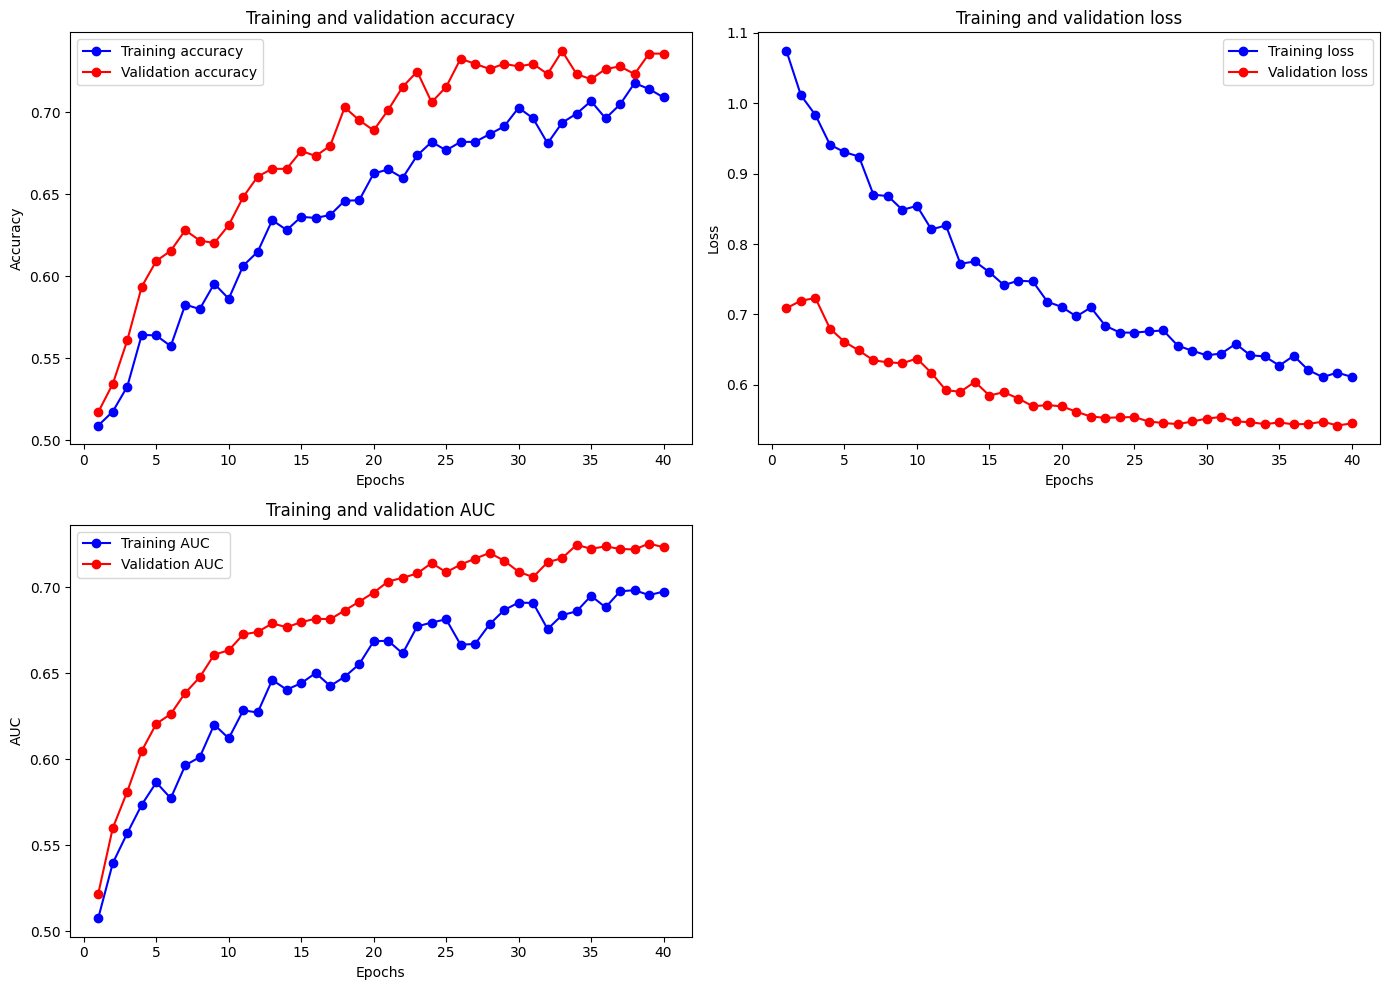


Model Number:  7
{'use_class_weights': False, 'clahe': True, 'trainable_start': -18, 'layer_size': 512, 'dropout': 0.4, 'learning_rate': 1e-05}
Accuracy:  0.77  / AUC:  0.77  / Loss:  0.49
Validation Accuracy:  0.75  / Validation AUC:  0.75  / Validation Loss:  0.52


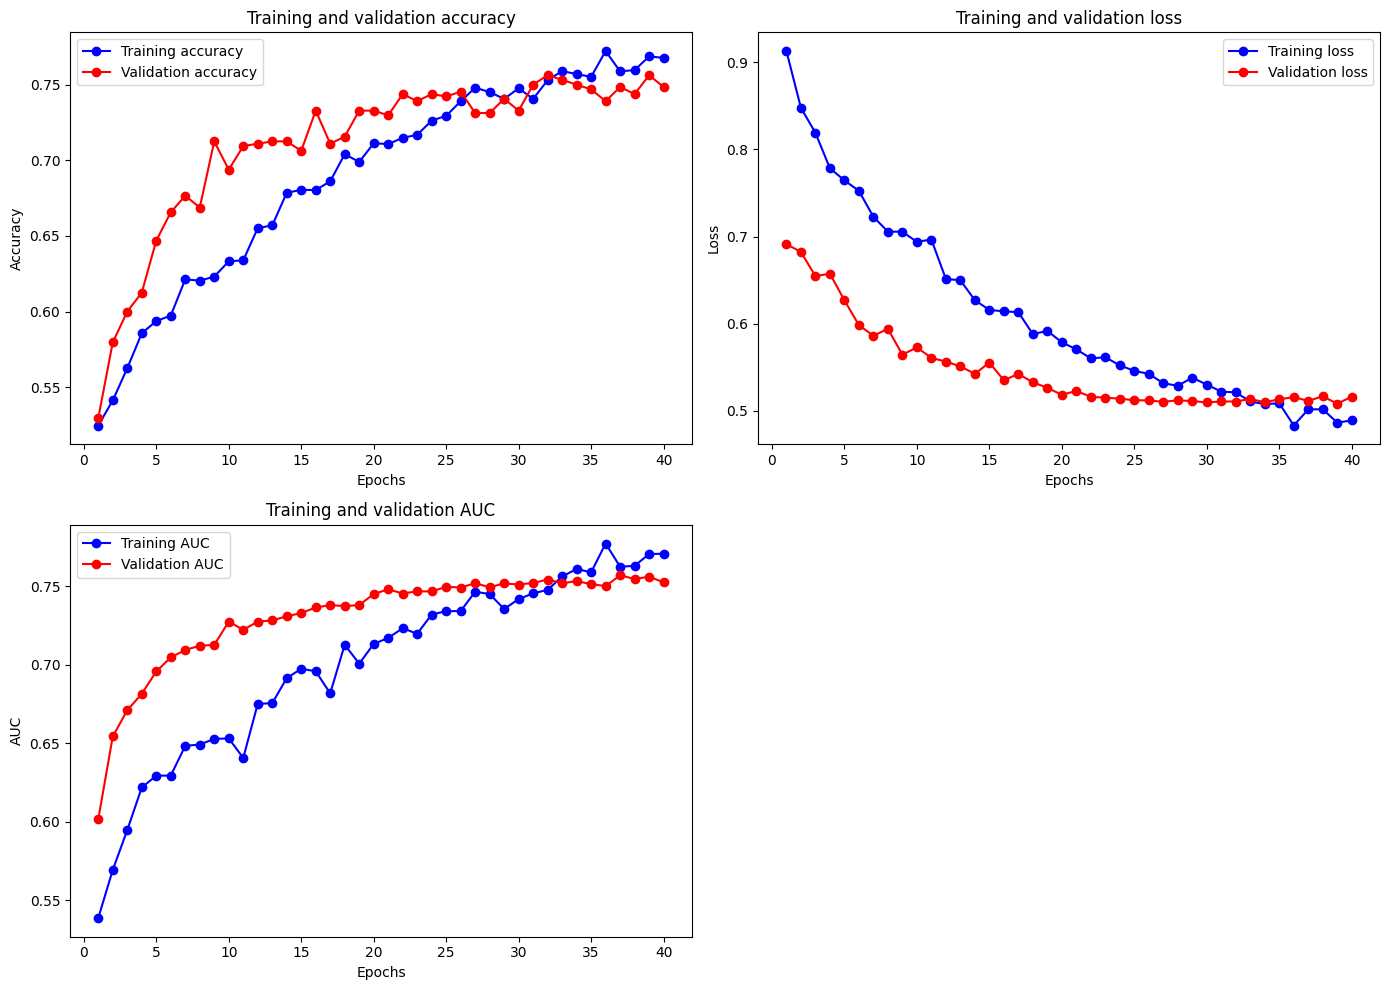


Model Number:  8
{'use_class_weights': False, 'clahe': True, 'trainable_start': -18, 'layer_size': 512, 'dropout': 0.5, 'learning_rate': 1e-05}
Accuracy:  0.75  / AUC:  0.75  / Loss:  0.53
Validation Accuracy:  0.74  / Validation AUC:  0.74  / Validation Loss:  0.53


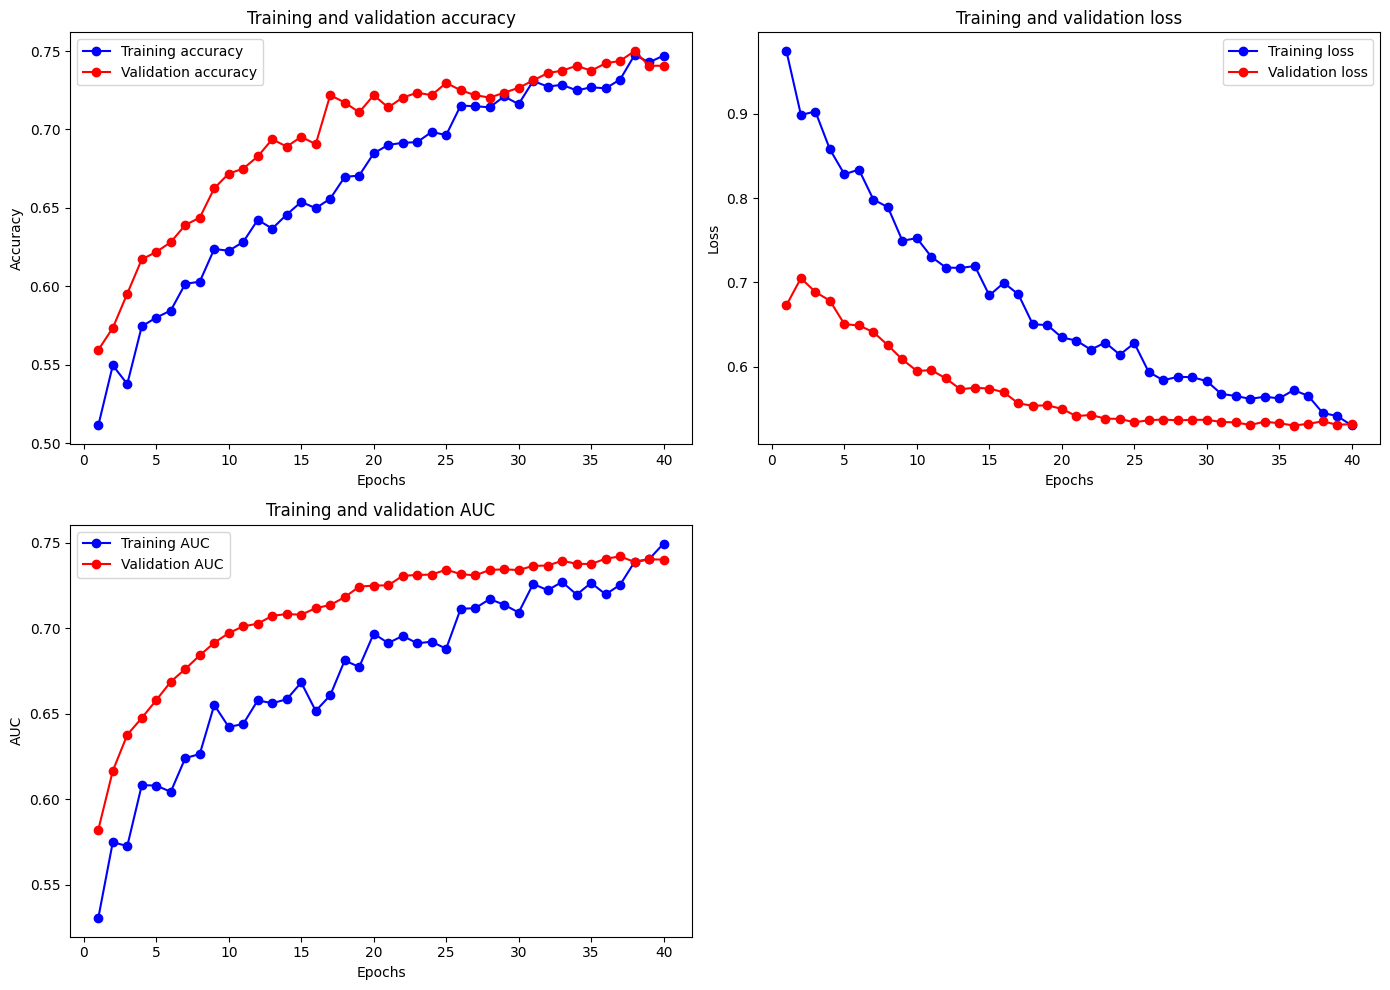


Model Number:  9
{'use_class_weights': False, 'clahe': True, 'trainable_start': -18, 'layer_size': 512, 'dropout': 0.6, 'learning_rate': 1e-05}
Accuracy:  0.71  / AUC:  0.71  / Loss:  0.61
Validation Accuracy:  0.73  / Validation AUC:  0.74  / Validation Loss:  0.54


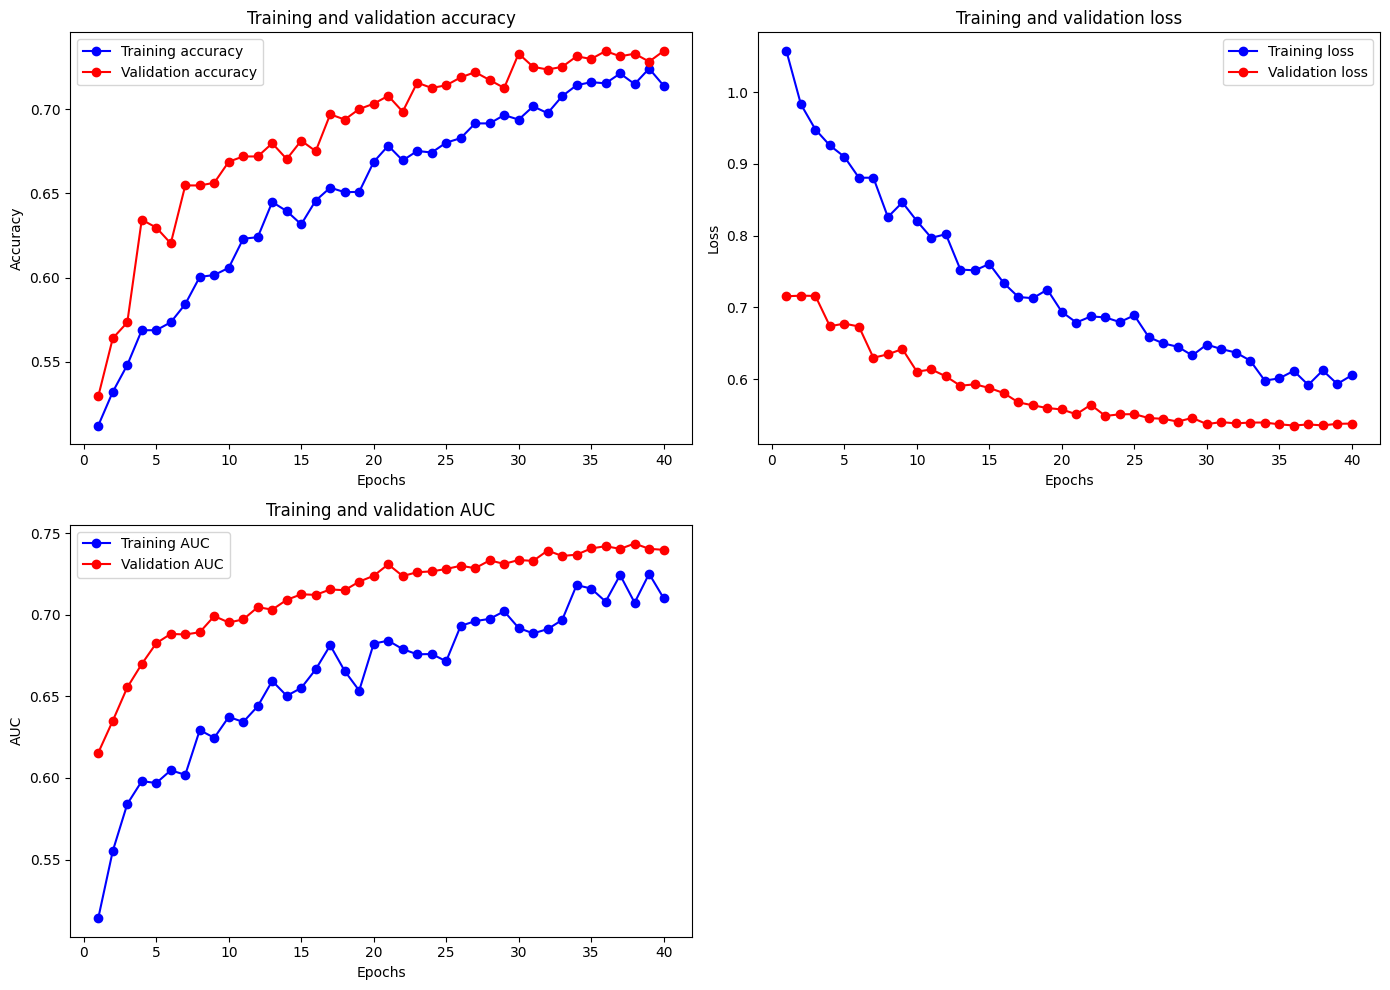

In [33]:
with open("grid_search_results.json", 'r') as f:
    results = [json.loads(line) for line in f][-9:]

    model_acc = []
    model_auc = []
    model_loss = []
    model_idx = []
    for result in results:
        model_acc.append(max(result['history']['val_acc']))
        model_auc.append(max(result['history']['val_auc']))
        model_loss.append(min(result['history']['val_loss']))
        model_idx.append(result['iteration'])

    print("Best Validation Accuracy: ", max(model_acc)*100, "% (Model Number: ", model_idx[model_acc.index(max(model_acc))], ")")
    print("Best Validation AUC: ", max(model_auc)*100, "% (Model Mumber: ", model_idx[model_auc.index(max(model_auc))], ")")
    print("Lowest Validation Loss: ", min(model_loss), "(Model Number: ", model_idx[model_loss.index(min(model_loss))], ")")

    # plot each model
    for result in results:
        print("\nModel Number: ", result['iteration'])
        print(result['params'])
        print("Accuracy: ", round(result['history']['acc'][-1], 2), " / AUC: ", round(result['history']['auc'][-1], 2), " / Loss: ", round(result['history']['loss'][-1], 2))
        print("Validation Accuracy: ", round(result['history']['val_acc'][-1], 2), " / Validation AUC: ", round(result['history']['val_auc'][-1], 2), " / Validation Loss: ", round(result['history']['val_loss'][-1], 2))
        plot_model_history(result['history'])


In [47]:
test_generator = DataGenerator(ftest, batch_size=batch_size, shape=(224, 224, 3), shuffle=False, clahe=True)

test_y = []
pred_y = []
test_paths = []
test_attrs = []
for i in range(test_generator.__len__()):
    batch_files = os.listdir(ftest)[i*batch_size:(i+1)*batch_size]
    batch_x, batch_y = test_generator.__getitem__(i)
    pred_batch_y = model.predict(batch_x, verbose=0)
    test_y.extend(batch_y.astype(int))
    #pred_y.extend((pred_batch_y > 0.5).astype(int))
    pred_y.extend(pred_batch_y)
    test_paths.extend(batch_files)
    test_attrs.extend([np.load(os.path.join(ftest,record))['male'] for record in batch_files])


Overall Accuracy: 0.2581151832460733
Overall AUC: 0.5391599597585514



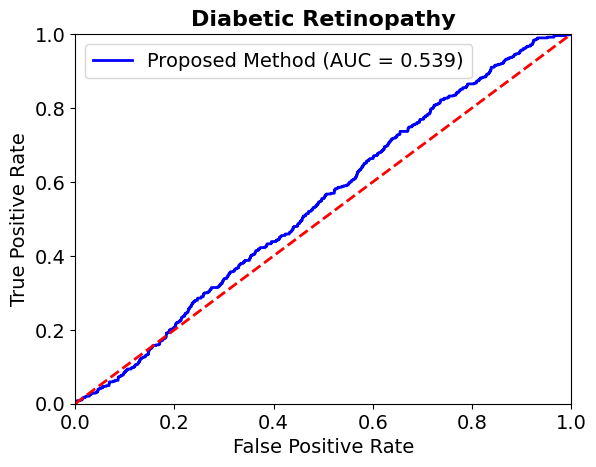

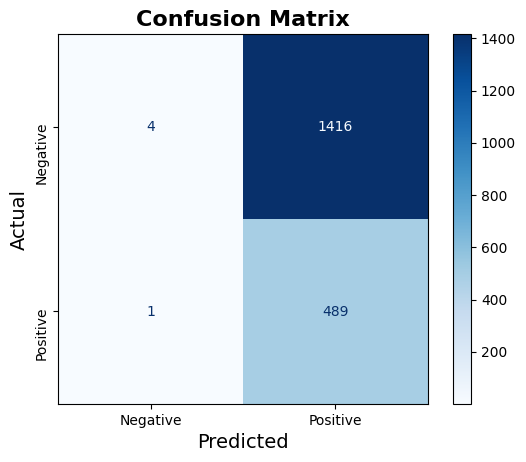

In [48]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def calc_auc(test_y, pred_y, msg='Overall'):
    test_y = np.array(test_y)
    pred_y = np.array(pred_y)

    fpr, tpr, _ = roc_curve(test_y, pred_y)
    auc_score = auc(fpr, tpr)
    acc = accuracy_score(test_y, np.rint(pred_y))

    print(f'{msg} Accuracy: {acc}')
    print(f'{msg} AUC: {auc_score}\n')

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Proposed Method (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Diabetic Retinopathy', fontsize=16, fontweight='bold')
    plt.legend(loc='best', fontsize=14)
    plt.show()

    return auc_score

def plot_confusion_matrix(test_y, pred_y, classes):
    cm = confusion_matrix(test_y, np.rint(pred_y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.yticks(rotation=90)
    plt.show()

auc_score = calc_auc(test_y, pred_y, 'Overall')
plot_confusion_matrix(test_y, pred_y, ['Negative', 'Positive'])

In [325]:
# subgroup performance analysis
test_y_gender = {'Male':[], 'Female':[]}
pred_y_gender = {'Male':[], 'Female':[]}

# write loop to build list of files for each race then calc_auc on each list
for i in range(len(test_attrs)):
    gender = test_attrs[i]

    # Seperate data by gender
    if gender == 1:
        test_y_gender['Male'].append(test_y[i])
        pred_y_gender['Male'].append(pred_y[i])
    elif gender == 0:
        test_y_gender['Female'].append(test_y[i])
        pred_y_gender['Female'].append(pred_y[i])


Male Accuracy: 0.7690802348336595
Male AUC: 0.7668591803937325



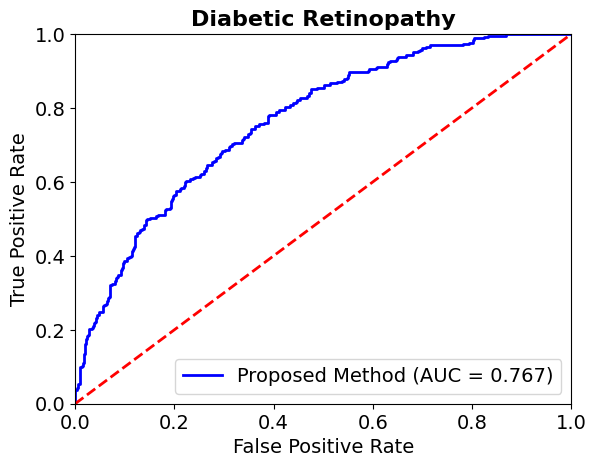

Female Accuracy: 0.7790432801822323
Female AUC: 0.7351391557676812



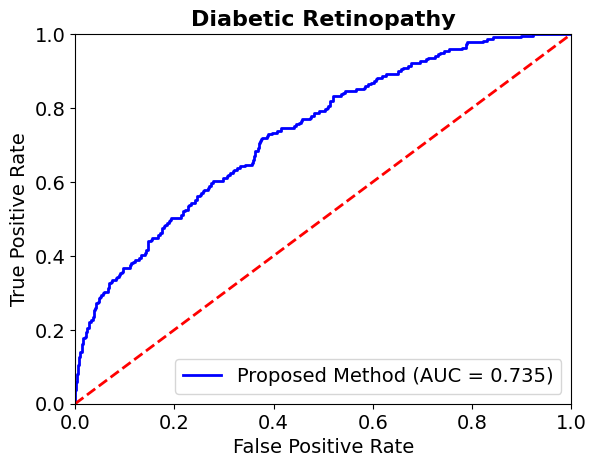

In [326]:
for k in test_y_gender.keys():
    auc_gender = calc_auc(test_y_gender[k], pred_y_gender[k], k)

In [ ]:
#save the model
model.save('{save_path}.h5')
model.load_model('{save_path}.h5',
                 test_y = test_y,
                 test_pred = pred_y,
                 test_attrs = test_attrs,
                 test_paths = test_paths,)

In [42]:
train_generator.use_vit = True
validation_generator.use_vit = True
test_generator.use_vit = True


def build_vit_model(dropout=0.2):
    base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    base_model.vit.pooler.trainable = False

    # inputs
    pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')
    
    # model layers
    vit = base_model.vit(pixel_values, training=True).last_hidden_state
    x = tf.keras.layers.Dropout(dropout)(vit[:, 0, :])
    classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(x)
    
    model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

    return model

vit_model = build_vit_model(dropout=0.5)

vit_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['acc', 'AUC']
)

vit_model.summary()

history = vit_model.fit(
    train_generator,
    epochs = 5,
    verbose = 1,
    validation_data = validation_generator,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7)]
)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_1  (None, 768)               0         
  (SlicingOpLambda)                                              
                                                           

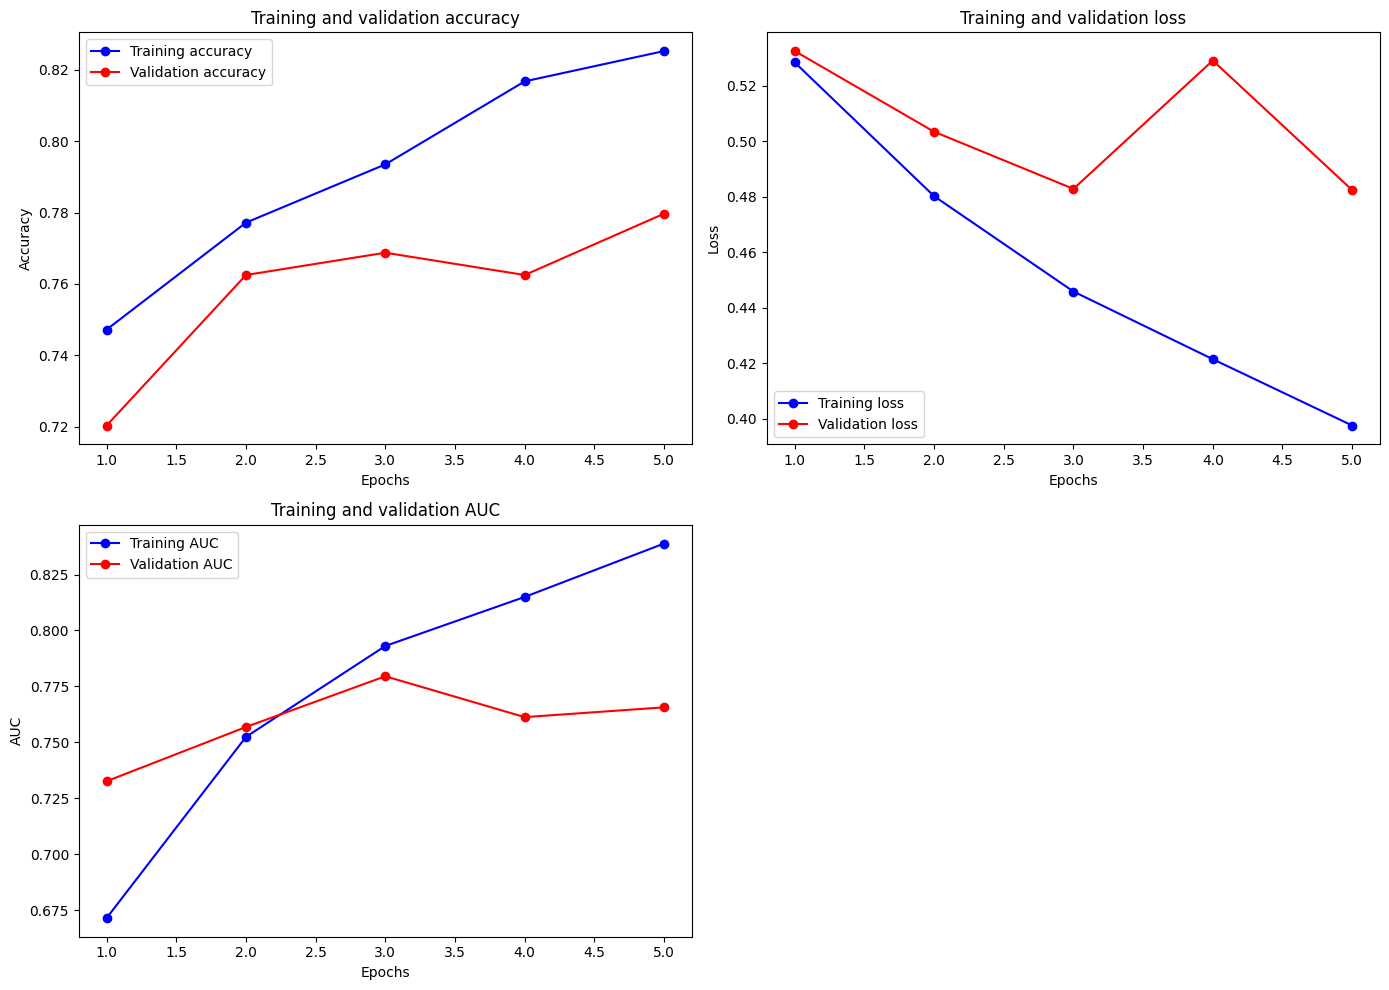

In [46]:
plot_model_history(history.history)

Overall Accuracy: 0.7942408376963351
Overall AUC: 0.777296636964645



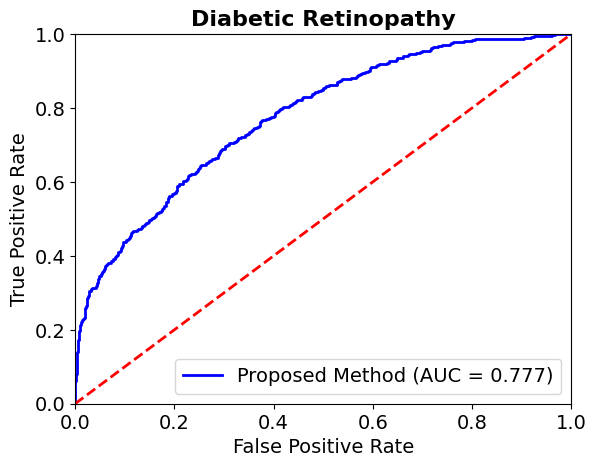

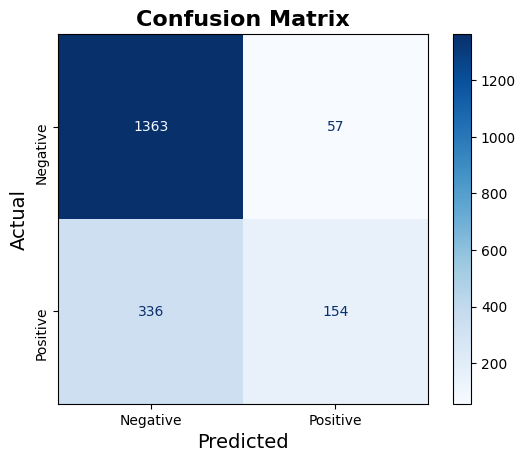

In [49]:
test_generator = DataGenerator(ftest, batch_size=batch_size, shape=(224, 224, 3), shuffle=False, clahe=True, use_vit=True)

test_y = []
pred_y = []
test_paths = []
test_attrs = []
for i in range(test_generator.__len__()):
    batch_files = os.listdir(ftest)[i*batch_size:(i+1)*batch_size]
    batch_x, batch_y = test_generator.__getitem__(i)
    pred_batch_y = vit_model.predict(batch_x, verbose=0)
    test_y.extend(batch_y.astype(int))
    #pred_y.extend((pred_batch_y > 0.5).astype(int))
    pred_y.extend(pred_batch_y)
    test_paths.extend(batch_files)
    test_attrs.extend([np.load(os.path.join(ftest,record))['male'] for record in batch_files])

auc_score = calc_auc(test_y, pred_y, 'Overall')
plot_confusion_matrix(test_y, pred_y, ['Negative', 'Positive'])

Male Accuracy: 0.7902912621359224
Male AUC: 0.7723209683832298



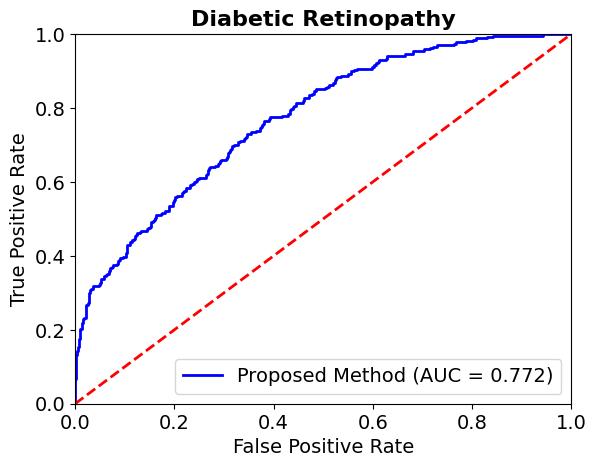

Female Accuracy: 0.7988636363636363
Female AUC: 0.7827535133880732



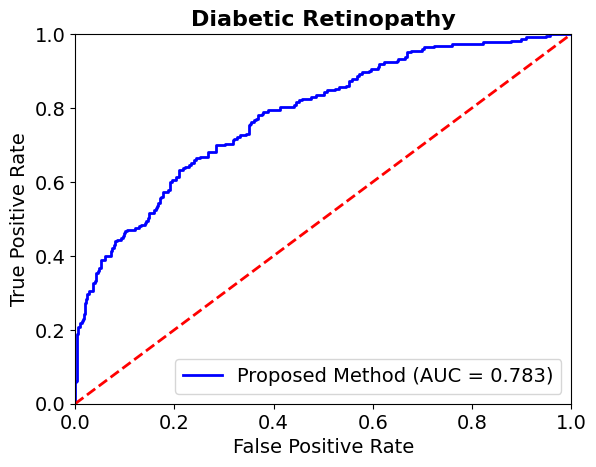

In [50]:
# subgroup performance analysis
test_y_gender = {'Male':[], 'Female':[]}
pred_y_gender = {'Male':[], 'Female':[]}

# write loop to build list of files for each race then calc_auc on each list
for i in range(len(test_attrs)):
    gender = test_attrs[i]

    # Seperate data by gender
    if gender == 1:
        test_y_gender['Male'].append(test_y[i])
        pred_y_gender['Male'].append(pred_y[i])
    elif gender == 0:
        test_y_gender['Female'].append(test_y[i])
        pred_y_gender['Female'].append(pred_y[i])

for k in test_y_gender.keys():
    auc_gender = calc_auc(test_y_gender[k], pred_y_gender[k], k)

In [ ]:

#save the model
date = datetime.now().strftime("%m-%d")
save_path = f"\\models\\vit_model_{auc_score:.2f}auc_{date}"

vit_model.save('{save_path}.h5')
np.savez('{save_path}.npz',
            test_y = test_y,
            test_pred = pred_y,
            test_attrs = test_attrs,
            test_paths = test_paths,
)

# Best Model
# tf.keras.models.load_model('\\models\\vit_model_0.78auc_11-30.h5')

#
#
### TO-DOs
- Finish labeling parts of notebook - add notes explaining decisions (i.e. class_weights)
- Ensure image normalization is happening on models as necessary
- Would greyscale work better?
- Try slight upsampling with hard-coded weights
- early stopping plateau